# Bitcoin-Altcoin arbitrage Strategy
* Anshul Agrawal (12211984 - aagrawal)
* Janet Zhang (12214546 - xiaodan1)
* Suraj Kaul (12214950 - skaul)

### Strategy

#### Why crypto?
* Cryptoassets have grown tremendously in recent year. Like stocks (and other asset classes), it seems that there is a common  underlying factor that affects the cryptoasset returns at least on shorter-horizons.
* We look at the leading common factor in the daily close-to-close cryptoasset returns is the prior day’s momentum (“mom”) and on average the subsequent open-to-close return is negatively correlated with mom.
* So, there is a mean-reversion effect in daily cryptoasset returns.
* The mean reversion effect is cross-sectional so we will need to consider multiple crypto assets.
  In stocks we can go short very easily but in the crypto markets this is not simple so in this trading strategy we are shorting bitcoins and buying the alternative cryptoassets.



In [78]:
from coinmarketcap import Market
import time
import matplotlib.pyplot as plt
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm
from bs4 import BeautifulSoup
import requests
import datetime
from iteration_utilities import flatten
import warnings
warnings.filterwarnings('ignore')

#### Importing Data for various coins from the coin market cap database

In [2]:
url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
parameters = {
  'start':'1',
  'limit':'5000',
  'convert':'USD'
}
headers = {
  'Accepts': 'application/json',
  'X-CMC_PRO_API_KEY': '2b91c0a4-c507-4963-8947-78745a0c89bc',
}

session = Session()
session.headers.update(headers)

try:
    response = session.get(url, params=parameters)
    data = json.loads(response.text)
except (ConnectionError, Timeout, TooManyRedirects) as e:
    print(e)

#### List of tickers ( cryptoassets ) in consideration

In [3]:
a = pd.DataFrame.from_dict(data['data'])
ticker_list = a['slug'].values
a['Date_of_Addition'] = 0 * len(a.index)
for i in range(len(a.index)):
    a.loc[i,'Date_of_Addition'] = datetime.datetime.strptime(a.loc[i,'date_added'], '%Y-%m-%dT%H:%M:%S.000Z')

print('Unique list of tickers',len(a.index))

Unique list of tickers 2238


#### Filtering out coins wich are recent additions in the crypto-markets 

In [13]:
d1 = datetime.datetime(2018, 1, 1) 
b = a.loc[a['Date_of_Addition'] < d1]
ticker = b['name'].values
print(len(b.index))

815


#### Fetching the data for the remaining cryptocurrencies from coinmarketcap
This takes a long time, we have the data directly attach as a csv which is imported below


In [ ]:
if False:
    crypto_df = []
    huge_df = pd.DataFrame()
    index_ = 0

    while(True):
        values = ticker[index_]
        url = "https://coinmarketcap.com/currencies/" + str(values) + "/historical-data/?start=20170101&end=20190526"
        content_r = requests.get(url)
        content= content_r.content
        if content_r.status_code == 200:
            soup = BeautifulSoup(content,'html.parser')
            table = soup.find('table', {'class': 'table'})
            try:
                data = [[td.text.strip() for td in tr.findChildren('td')] for tr in table.findChildren('tr')]

                df = pd.DataFrame(data)
                df.drop(df.index[0], inplace=True) # first row is empty
                df[0] =  pd.to_datetime(df[0]) # date
                print(values,"done...")
                for i in range(1,7):
                    df[i] = pd.to_numeric(df[i].str.replace(",","").str.replace("-","")) # some vol is missing and has -
                df.columns = ['Date',values+'/Open',values+'/High',values+'/Low',values+'/Close',values+'/Volume',values+'/Market Cap']
                df.set_index('Date',inplace=True)
                df.sort_index(inplace=True, ascending = True)
                huge_df=pd.concat([huge_df,df],axis=1)

            except Exception as e:
                print(e)
                print(values,"not found")
                continue
            index_=index_+1
        elif content_r.status_code==429: 
            print(values,"not found")
            time.sleep(65)

#### Labelling the columns and creating the final dataframe for analysis

In [8]:
if False:
    df = pd.DataFrame(data)
    df.drop(df.index[0], inplace = True) # first row is empty
    df[0] =  pd.to_datetime(df[0]) # date

    for i in range(1,7):
        df[i] = pd.to_numeric(df[i].str.replace(",","").str.replace("-","")) # some vol is missing and has -
    df.columns = ['Date',values+'/Open',values+'/High',values+'/Low',values+'/Close',values+'/Volume',values+'/Market Cap']
    df.set_index('Date',inplace = True)
    df.sort_index(inplace = True, ascending = True)

    huge_df = pd.concat([huge_df,df],axis = 1)
    huge_df.head()

#### Writing the data to excel file so we can directly run the code from this once the data is ready

In [ ]:
if False:
    huge_df.to_csv("2y_818coins_data.csv")

####  Directly importing the csv file/data instead of scrapping the coingbase wesbite

In [3]:
df = pd.read_csv("2y_818coins_data_v2.csv").set_index("Date")
df.index = pd.to_datetime(df.index)
df.head()

,bitcoin/Open,bitcoin/High,bitcoin/Low,bitcoin/Close,bitcoin/Volume,bitcoin/Market Cap,ethereum/Open,ethereum/High,ethereum/Low,ethereum/Close,...,dynamiccoin/Low,dynamiccoin/Close,dynamiccoin/Volume,dynamiccoin/Market Cap,pabyosi-coin-special/Open,pabyosi-coin-special/High,pabyosi-coin-special/Low,pabyosi-coin-special/Close,pabyosi-coin-special/Volume,pabyosi-coin-special/Market Cap
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,963.66,1003.08,958.70,998.33,147775008,16050407461,7.98,8.47,7.98,8.17,...,0.025480,0.030680,30.0,NaN,0.212226,0.233108,0.211345,0.220340,6578.0,NaN
2017-01-02,998.62,1031.39,996.70,1021.75,222184992,16429024775,8.17,8.44,8.05,8.38,...,0.020093,0.028151,146.0,NaN,0.220405,0.241318,0.219510,0.222752,7194.0,NaN
2017-01-03,1021.60,1044.08,1021.60,1043.84,185168000,16786368910,8.37,10.00,8.32,9.73,...,0.024055,0.024281,35.0,NaN,0.222719,0.288807,0.222719,0.231732,12578.0,NaN
2017-01-04,1044.40,1159.42,1044.40,1154.73,344945984,18571869009,9.71,11.28,9.56,11.25,...,0.012188,0.029043,311.0,NaN,0.231857,0.287545,0.231857,0.243798,31408.0,NaN
2017-01-05,1156.73,1191.10,910.42,1013.38,510199008,16300254795,11.29,11.89,9.40,10.25,...,0.012359,0.022179,30.0,NaN,0.255869,0.276961,0.191652,0.273613,28965.0,NaN


In [4]:
tick_list = []
for cols in df.columns:
    a,b = cols.split("/") 
    tick_list.append(a)
    
tick_list = list(set(tick_list))

#### lambda functions for selecting columns 

In [5]:
f1 = lambda x : [x+"/Close", x+"/High",x+"/Low",x+'/Market Cap',x+'/Open',x+"/Volume"]
f2 = lambda x,col_name : [x + "/" + col_name]
f3 = lambda x,col_name : list(flatten([f2(i,col_name) for i in x]))
f4 = lambda x : [x+"/Close", x+"/High",x+"/Low",x+'/Market Cap',x+'/Open',x+"/Volume",x+"/Cash",x+"/Position",x+"/Pnl"]

In [6]:
df[f1("bitcoin")].head()

,bitcoin/Close,bitcoin/High,bitcoin/Low,bitcoin/Market Cap,bitcoin/Open,bitcoin/Volume
Date,,,,,,
2017-01-01,998.33,1003.08,958.70,16050407461,963.66,147775008
2017-01-02,1021.75,1031.39,996.70,16429024775,998.62,222184992
2017-01-03,1043.84,1044.08,1021.60,16786368910,1021.60,185168000
2017-01-04,1154.73,1159.42,1044.40,18571869009,1044.40,344945984
2017-01-05,1013.38,1191.10,910.42,16300254795,1156.73,510199008


In [7]:
temp = df.reindex(sorted(df.columns), axis = 1).dropna(axis = 1)
temp.head()

,1337coin/Close,1337coin/High,1337coin/Low,1337coin/Market Cap,1337coin/Open,1337coin/Volume,2give/Close,2give/High,2give/Low,2give/Market Cap,...,zeitcoin/High,zeitcoin/Low,zeitcoin/Market Cap,zeitcoin/Open,zeitcoin/Volume,zetacoin/Close,zetacoin/High,zetacoin/Low,zetacoin/Market Cap,zetacoin/Open
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.000001,0.000001,9.600000e+07,18480,9.800000e+07,857,0.000330,0.000380,0.000328,167098,...,0.000009,0.000005,238084,0.000008,53,0.002433,0.002643,0.001879,402227,0.002426
2017-01-02,0.000002,0.000002,1.000000e-06,34592,1.000000e-06,59,0.000276,0.000349,0.000272,139635,...,0.000008,0.000006,263759,0.000007,24,0.002445,0.002452,0.001758,404319,0.002433
2017-01-03,0.000002,0.000002,1.000000e-06,27355,2.000000e-06,17,0.000380,0.000380,0.000276,192346,...,0.000007,0.000003,241389,0.000007,72,0.002369,0.002462,0.002341,391608,0.002446
2017-01-04,0.000001,0.000002,8.300000e+07,16075,2.000000e-06,159,0.000392,0.000465,0.000357,198524,...,0.000007,0.000003,233710,0.000007,47,0.002230,0.002470,0.002008,368648,0.002368
2017-01-05,0.000001,0.000001,9.000000e+07,20043,1.000000e-06,24,0.000263,0.000395,0.000237,133004,...,0.000008,0.000003,215564,0.000006,32,0.002270,0.002574,0.002203,375359,0.002217


####  Selecting only securities that have all 6 data columns available

In [8]:
l = []
for tick in tick_list:
    try:
        temp[f1(tick)]
        l.append(tick)
    except:
        continue
del temp

In [9]:
tick_list = l
len(tick_list)

116

#### Filtering out the securities which have incorrect prices flowing in from coinmarketcap

In [10]:
a = df[f3(tick_list,"Close")].pct_change().fillna(0).abs().max(axis = 0).sort_values() > 1e3
a.tail()

stealth/Close        False
pascal-coin/Close    False
newyorkcoin/Close     True
litedoge/Close        True
1337coin/Close        True
dtype: bool

In [11]:
tick_list.remove("1337coin")
tick_list.remove("litedoge")
tick_list.remove("newyorkcoin")

In [12]:
len(tick_list)

113

####  Keeping only the columns for relevant tickers

In [13]:
col_list = list(flatten([f1(x) for x in tick_list]))
df = df[col_list]
df.head()

,diamond/Close,diamond/High,diamond/Low,diamond/Market Cap,diamond/Open,diamond/Volume,decred/Close,decred/High,decred/Low,decred/Market Cap,...,bitbay/Low,bitbay/Market Cap,bitbay/Open,bitbay/Volume,gridcoin/Close,gridcoin/High,gridcoin/Low,gridcoin/Market Cap,gridcoin/Open,gridcoin/Volume
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.149706,0.219274,0.149685,283545,0.219242,3152,0.490000,0.516169,0.467199,1705650,...,0.000853,967665,0.000924,2278,0.007478,0.007722,0.006963,2875271,0.007243,7962
2017-01-02,0.153125,0.188489,0.126099,290171,0.149789,1607,0.472282,0.504779,0.437467,1647544,...,0.000947,1038695,0.000947,2032,0.007172,0.007786,0.007160,2757774,0.007482,1595
2017-01-03,0.174883,0.177023,0.136432,331649,0.153119,1689,0.461408,0.487481,0.451906,1613098,...,0.000982,1019936,0.001031,1664,0.006590,0.007485,0.006087,2534107,0.007238,12618
2017-01-04,0.179122,0.182306,0.167391,339927,0.174843,155,0.656956,0.697568,0.461302,2302024,...,0.000804,1091554,0.001013,4009,0.006929,0.007018,0.005959,2664918,0.006588,10939
2017-01-05,0.222286,0.224407,0.146614,422076,0.179306,1742,0.551482,0.710632,0.498772,1936634,...,0.000846,915315,0.001074,1989,0.005830,0.007143,0.005252,2242610,0.006936,1727


#### Creating momentum factor and the trading signal from the momentum factor

We use a heaviside($\theta$) function to create a trading signal($\alpha$) from the momentum factor.
    
$\alpha_{is} = \theta(-\beta_{is}^{mom}) $

where

>$\beta_{is}^{mom} = R_{i,s+1}$,

>$\theta(x) = 1$ if  $x > 0$, or
>$\theta(x) = 0$ if  $x < 0$

In [14]:
for ticks in tick_list:
    df[ticks+"/mom"] = np.log(df.loc[:,ticks+'/Close']/df.loc[:,ticks+'/Open']).shift(1).fillna(0)
    df[ticks+"/ret"] = (df.loc[:,ticks+'/Close']/df.loc[:,ticks+'/Open'] - 1 )
    df[ticks+"/alpha"] = np.heaviside(- df.loc[:,ticks+"/mom"],0)    

In [15]:
df = df.reindex(sorted(df.columns), axis = 1)
df.head()

,2give/Close,2give/High,2give/Low,2give/Market Cap,2give/Open,2give/Volume,2give/alpha,2give/mom,2give/ret,adzcoin/Close,...,zcoin/ret,zeitcoin/Close,zeitcoin/High,zeitcoin/Low,zeitcoin/Market Cap,zeitcoin/Open,zeitcoin/Volume,zeitcoin/alpha,zeitcoin/mom,zeitcoin/ret
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.000330,0.000380,0.000328,167098,0.000337,10,0.0,0.000000,-0.020772,0.013499,...,0.009705,0.000007,0.000009,0.000005,238084,0.000008,53,0.0,0.000000,-0.125
2017-01-02,0.000276,0.000349,0.000272,139635,0.000330,11,1.0,-0.020990,-0.163636,0.011208,...,-0.000661,0.000007,0.000008,0.000006,263759,0.000007,24,1.0,-0.133531,0.000
2017-01-03,0.000380,0.000380,0.000276,192346,0.000276,10,1.0,-0.178692,0.376812,0.013479,...,0.241606,0.000007,0.000007,0.000003,241389,0.000007,72,0.0,0.000000,0.000
2017-01-04,0.000392,0.000465,0.000357,198524,0.000380,10,0.0,0.319770,0.031579,0.016497,...,0.014102,0.000007,0.000007,0.000003,233710,0.000007,47,0.0,0.000000,0.000
2017-01-05,0.000263,0.000395,0.000237,133004,0.000393,67,0.0,0.031091,-0.330789,0.016763,...,-0.190692,0.000006,0.000008,0.000003,215564,0.000006,32,0.0,0.000000,0.000


####  Removing BTC as we do not trade that directly but use it later for hedging

In [16]:
tick_list.remove("bitcoin")

### Daily and Weekly Trading Strategy
1. In both of case we buy \$1 worth of security
2. Our criteria for buying/entry is  $\alpha_{is} >0 $
3. Exit criteria when $\alpha_{is} =0$

In [17]:
def daily_trading(df,tick_list):
    df = df.copy()
    for ticks in tick_list:
        df[ticks+"/Cash"]=0.0
        df[ticks+"/Position"]=0.0
        df[ticks+"/Pnl"]=0.0
        for today in df.index:
            if today == df.index[0]:
                if df.loc[today,ticks+"/alpha"] > 0 and df.loc[yesterday,ticks+'/Position']==0: 
                    df.loc[today,ticks+'/Position'] = 1 / df.loc[today,ticks + '/Close']
                    df.loc[today,ticks+'/Cash'] = - 1

            else:
                if df.loc[today,ticks+"/alpha"] > 0 and df.loc[yesterday,ticks+'/Position']==0: 
                    df.loc[today,ticks+'/Position'] = 1 / df.loc[today,ticks + '/Close']
                    df.loc[today,ticks+'/Cash'] = - 1

                elif df.loc[today,ticks+"/alpha"] == 0 and df.loc[yesterday,ticks+'/Position']>0.0 and df.loc[yesterday,ticks+"/alpha"]: 
                    df.loc[today,ticks+'/Cash'] = df.loc[yesterday,ticks+'/Position'] * df.loc[today,ticks + '/Close']    
                    df.loc[today,ticks+'/Position'] = 0.0
                else:
                    df.loc[today,ticks+'/Position'] = df.loc[yesterday,ticks+'/Position'] 

            df.loc[:,ticks+'/Pnl'] = np.where(df.loc[:,ticks+'/Cash']>0.0,df.loc[:,ticks + '/Cash'].cumsum(),0)
            yesterday=today
            
    return df

In [18]:
def weekly_trading(df,tick_list,hedge=False):
    
    df = df.copy()
    mondays = df[df.index.dayofweek == 0].index
    fridays = df[df.index.dayofweek == 4].index
    for ticks in tick_list:
        df[ticks+"/Cash"] = 0.0
        df[ticks+"/Position"] = 0.0
        df[ticks+"/Pnl"] = 0.0

        for entry,exit in zip(mondays,fridays):
            if df.loc[entry,ticks+"/alpha"] > 0: 
                df.loc[entry:exit,ticks+'/Position'] = 1 / df.loc[entry,ticks + '/Close']
                df.loc[entry,ticks+'/Cash'] = - 1
                df.loc[exit,ticks+'/Position'] = 0.0
                df.loc[exit,ticks+'/Cash'] = + df.loc[entry,ticks+'/Position'] * df.loc[exit,ticks + '/Close']
                df.loc[exit,ticks+"/Pnl"] = df.loc[exit,ticks+'/Cash'] - 1 
    df["agg_pnl"]=0.0
    df["cash_invested"]=0.0
    df["return"]=0.0
    for entry,exit in zip(mondays,fridays):
        df.loc[exit,"agg_pnl"] = df.loc[exit,f3(tick_list,"Pnl")].sum()
        df.loc[exit,"cash_invested"] = df.loc[entry,f3(tick_list,"Cash")].abs().sum()
        df.loc[exit,"return"] = df.loc[exit,"agg_pnl"] /df.loc[exit,"cash_invested"]

    return df

### 1. Daily Trading using $\alpha_{is}$

In [74]:
df_daily = daily_trading(df,tick_list)
df_daily.head(10)

,2give/Close,2give/High,2give/Low,2give/Market Cap,2give/Open,2give/Volume,2give/alpha,2give/mom,2give/ret,adzcoin/Close,...,monetaryunit/Pnl,memetic/Cash,memetic/Position,memetic/Pnl,feathercoin/Cash,feathercoin/Position,feathercoin/Pnl,cloakcoin/Cash,cloakcoin/Position,cloakcoin/Pnl
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.000330,0.000380,0.000328,167098,0.000337,10,0.0,0.000000,-0.020772,0.013499,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2017-01-02,0.000276,0.000349,0.000272,139635,0.000330,11,1.0,-0.020990,-0.163636,0.011208,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2017-01-03,0.000380,0.000380,0.000276,192346,0.000276,10,1.0,-0.178692,0.376812,0.013479,...,0.096229,0.0,0.000000,0.0,-1.000000,161.733786,0.000000,0.0,0.000000,0.0
2017-01-04,0.000392,0.000465,0.000357,198524,0.000380,10,0.0,0.319770,0.031579,0.016497,...,0.000000,0.0,0.000000,0.0,1.037361,0.000000,0.037361,0.0,0.000000,0.0
2017-01-05,0.000263,0.000395,0.000237,133004,0.000393,67,0.0,0.031091,-0.330789,0.016763,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,-1.0,4.581125,0.0
2017-01-06,0.000271,0.000274,0.000212,136965,0.000263,58,1.0,-0.401656,0.030418,0.015441,...,0.000000,0.0,0.000000,0.0,-1.000000,185.150898,0.000000,0.0,4.581125,0.0
2017-01-07,0.000382,0.000464,0.000250,193195,0.000271,466,0.0,0.029965,0.409594,0.016206,...,0.000000,0.0,0.000000,0.0,0.000000,185.150898,0.000000,0.0,4.581125,0.0
2017-01-08,0.000446,0.000485,0.000378,225753,0.000382,1,0.0,0.343302,0.167539,0.016036,...,0.000000,0.0,0.000000,0.0,1.085169,0.000000,0.122530,0.0,4.581125,0.0
2017-01-09,0.000343,0.000448,0.000339,173754,0.000447,13,0.0,0.154898,-0.232662,0.015588,...,0.013470,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,4.581125,0.0


### 2. Weekly trading using $\alpha_{is}$
* We enter positions every monday, and exit them on Friday

In [19]:
df_weekly = weekly_trading(df,tick_list)

### Quantile based trading strategy

In [29]:
def rank_mom(df,tick_list,long_stocks_count = 5):
    
    df = df.copy()
    mom_tickers = f3(tick_list,"mom")
    
    df = df[mom_tickers]
    df.index = tick_list
    data_series = df
    a = data_series.sort_values()
    a.dropna(axis = 0,how = 'any', inplace = True)
    long_stock = a.iloc[::-1].index[-long_stocks_count:]
    
    return list(long_stock)

#### For beta hedging using BTC

In [30]:
def beta_reg(df,tick_list,trade_date):
    
    df = df.copy()    
    list_cols = f3(tick_list,"ret")
    previous_date = trade_date - pd.Timedelta("30 days")
    X = df.loc[previous_date:trade_date,list_cols].mean(axis = 1)
    Y = df.loc[previous_date:trade_date,"bitcoin/ret"]
    model = sm.OLS(Y,X)
    results = model.fit()
    
    return results.params

In [251]:
def weekly_trading_mom(df,tick_list,hedge = False):
    
    df = df.copy()
    mondays = df[df.index.dayofweek == 0].index
    fridays = df[df.index.dayofweek == 4].index
    
    for ticks in tick_list:
        df[ticks+"/Cash"] = 0.0
        df[ticks+"/Position"] = 0.0
        df[ticks+"/Pnl"] = 0.0
        
    df['bitcoin/Cash'] = 0.0
    df['bitcoin/Position'] = 0.0
    df["bitcoin/Pnl"] = 0.0
    df['beta'] = np.nan
    
    df["agg_pnl"]=0.0
    df["cash_invested"]=0.0
    df["return"]=0.0
    
    for entry,exit in zip(mondays,fridays):
        tick_bought = rank_mom(df.loc[entry],tick_list)
        for ticks in tick_bought: 
            df.loc[entry,ticks+'/Position'] = 1 / df.loc[entry,ticks + '/Close']
            df.loc[entry,ticks+'/Cash'] = - 1
            df.loc[exit,ticks+'/Position'] = 0.0
            df.loc[exit,ticks+'/Cash'] = + df.loc[entry,ticks+'/Position'] * df.loc[exit,ticks + '/Close']
            df.loc[exit,ticks+"/Pnl"] = df.loc[exit,ticks+'/Cash'] - 1
        if hedge:
            #print("here")
            x = beta_reg(df,tick_bought,entry)[0]
            df.loc[entry,'beta'] =  x
            df.loc[entry,'bitcoin/Position'] = - x / df.loc[entry, 'bitcoin/Close']
            df.loc[entry,'bitcoin/Cash'] =  x
            df.loc[exit,'bitcoin/Position'] = 0.0
            df.loc[exit,'bitcoin/Cash'] =  df.loc[entry,'bitcoin/Position'] * df.loc[exit, 'bitcoin/Close']
            df.loc[exit,"bitcoin/Pnl"] = df.loc[exit,'bitcoin/Cash'] + x
        tick_list.append("bitcoin")
        #print(tick_list)
        df.loc[exit,"agg_pnl"] = df.loc[exit,f3(tick_list,"Pnl")].sum()
        df.loc[exit,"cash_invested"] = df.loc[entry,f3(tick_list,"Cash")].abs().sum()
        df.loc[exit,"return"] = df.loc[exit,"agg_pnl"] /df.loc[exit,"cash_invested"]
        tick_list.remove("bitcoin")
        #print(tick_list)

    
    return df

### 3. Quantile Long only 
1. We rank the stocks based on the momentum factor, and then we only buy the top 5 -ve ranked momentum stocks on a given day.
2. Weekly rebalancing

In [198]:
df_mom_weekly = weekly_trading_mom(df,tick_list)

In [33]:
df_mom_weekly.head(10)

,2give/Close,2give/High,2give/Low,2give/Market Cap,2give/Open,2give/Volume,2give/alpha,2give/mom,2give/ret,adzcoin/Close,...,gridcoin/Cash,gridcoin/Position,gridcoin/Pnl,bitcoin/Cash,bitcoin/Position,bitcoin/Pnl,beta,agg_pnl,cash_invested,return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,0.000485,0.000486,0.000352,246022,0.000352,1,0.0,0.034686,0.377841,0.045231,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.000000,0.0,0.000000
2017-02-01,0.000442,0.000486,0.000420,224103,0.000485,1,0.0,0.320518,-0.088660,0.057368,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.000000,0.0,0.000000
2017-02-02,0.000435,0.000498,0.000394,220527,0.000442,222,1.0,-0.092839,-0.015837,0.055542,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.000000,0.0,0.000000
2017-02-03,0.000482,0.002678,0.000367,244464,0.000435,4468,1.0,-0.015964,0.108046,0.056785,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,-0.028944,5.0,-0.005789
2017-02-04,0.000448,0.000553,0.000426,227365,0.000483,202,0.0,0.102598,-0.072464,0.054710,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.000000,0.0,0.000000


### 4. BTC beta Hedged 
1. We use BTC has a beta hedge for our Quantile based Long trading stratergy
2. This also provides us with leverage, as we are able to use the Short Sale proceeds from BTC Futures
3. Weekly rebalancing

In [269]:
df_mom_weekly_hedged = weekly_trading_mom(df,tick_list,hedge=True)

In [253]:
df_mom_weekly_hedged[f4("bitcoin")]

,bitcoin/Close,bitcoin/High,bitcoin/Low,bitcoin/Market Cap,bitcoin/Open,bitcoin/Volume,bitcoin/Cash,bitcoin/Position,bitcoin/Pnl
Date,,,,,,,,,
2017-01-01,998.33,1003.08,958.70,16050407461,963.66,147775008,0.000000,0.000000e+00,0.000000
2017-01-02,1021.75,1031.39,996.70,16429024775,998.62,222184992,-0.199704,1.954526e-04,0.000000
2017-01-03,1043.84,1044.08,1021.60,16786368910,1021.60,185168000,0.000000,0.000000e+00,0.000000
2017-01-04,1154.73,1159.42,1044.40,18571869009,1044.40,344945984,0.000000,0.000000e+00,0.000000
2017-01-05,1013.38,1191.10,910.42,16300254795,1156.73,510199008,0.000000,0.000000e+00,0.000000
2017-01-06,902.20,1046.81,883.94,14513695758,1014.24,351876000,0.176337,0.000000e+00,-0.023366
2017-01-07,908.59,908.59,823.56,14618030536,903.49,279550016,0.000000,0.000000e+00,0.000000
2017-01-08,911.20,942.72,887.25,14661966429,908.17,158715008,0.000000,0.000000e+00,0.000000
2017-01-09,902.83,913.69,879.81,14528815565,913.24,141876992,0.236232,-2.616569e-04,0.000000


In [231]:
df_mom_weekly_hedged.head()

,2give/Close,2give/High,2give/Low,2give/Market Cap,2give/Open,2give/Volume,2give/alpha,2give/mom,2give/ret,adzcoin/Close,...,gridcoin/Cash,gridcoin/Position,gridcoin/Pnl,bitcoin/Cash,bitcoin/Position,bitcoin/Pnl,beta,agg_pnl,cash_invested,return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.000330,0.000380,0.000328,167098,0.000337,10,0.0,0.000000,-0.020772,0.013499,...,0.0,0.0,0.0,0.000000,0.000000,0.0,NaN,0.0,0.0,0.0
2017-01-02,0.000276,0.000349,0.000272,139635,0.000330,11,1.0,-0.020990,-0.163636,0.011208,...,0.0,0.0,0.0,-0.199704,-0.000195,0.0,0.199704,0.0,0.0,0.0
2017-01-03,0.000380,0.000380,0.000276,192346,0.000276,10,1.0,-0.178692,0.376812,0.013479,...,0.0,0.0,0.0,0.000000,0.000000,0.0,NaN,0.0,0.0,0.0
2017-01-04,0.000392,0.000465,0.000357,198524,0.000380,10,0.0,0.319770,0.031579,0.016497,...,0.0,0.0,0.0,0.000000,0.000000,0.0,NaN,0.0,0.0,0.0
2017-01-05,0.000263,0.000395,0.000237,133004,0.000393,67,0.0,0.031091,-0.330789,0.016763,...,0.0,0.0,0.0,0.000000,0.000000,0.0,NaN,0.0,0.0,0.0


### 5. Quantile Long -Short
1. Althought directly shorting cryptos is not possible right now (except for BTC), we explore the possible on a Long - Short Quantile trading stratergy
2. As shorting is more expensive we are short only 5 alt coins and buying 10 alt coins
3. Weekly rebalancing

In [201]:
def rank_mom_ls(df,tick_list,stocks_count = 5):
    df = df.copy()
    mom_tickers = f3(tick_list,"mom")
    
    b = df[mom_tickers]
    b.index=tick_list
    a = b.sort_values()
    a.dropna(axis = 0,how = 'any', inplace = True)
    short_stock = a.iloc[::-1].index[:stocks_count]
    long_stock = a.iloc[::-1].index[-stocks_count-5:]
    
    return (long_stock,short_stock)

In [202]:
def weekly_trading_mom_ls(df,tick_list):
    df=df.copy()
    mondays=df[df.index.dayofweek==0].index
    fridays=df[df.index.dayofweek==4].index
    df["agg_pnl"]=0.0
    df["cash_invested"]=0.0
    df["return"]=0.0
    
    for ticks in tick_list:
        df[ticks+"/Cash"]=0.0
        df[ticks+"/Position"]=0.0
        df[ticks+"/Pnl"]=0.0
    df['bitcoin/Cash']=0.0
    df['bitcoin/Position']=0.0
    df["bitcoin/Pnl"]=0.0
    for entry,exit in zip(mondays,fridays):
        tick_bought,tick_sold=rank_mom_ls(df.loc[entry],tick_list)
        #print(tick_bought)
        for ticks in tick_bought: 
            df.loc[entry,ticks+'/Position'] = 1 / df.loc[entry,ticks + '/Close']
            df.loc[entry,ticks+'/Cash'] = - 1
            df.loc[exit,ticks+'/Position'] = 0.0
            df.loc[exit,ticks+'/Cash'] = + df.loc[entry,ticks+'/Position'] * df.loc[exit,ticks + '/Close']
            df.loc[exit,ticks+"/Pnl"] = df.loc[exit,ticks+'/Cash'] - 1
        #print(tick_sold)
        for ticks in tick_sold: 
            df.loc[entry,ticks+'/Position'] = -1 / df.loc[entry,ticks + '/Close']
            df.loc[entry,ticks+'/Cash'] = + 1
            df.loc[exit,ticks+'/Position'] = 0.0
            df.loc[exit,ticks+'/Cash'] = + df.loc[entry,ticks+'/Position'] * df.loc[exit,ticks + '/Close']
            df.loc[exit,ticks+"/Pnl"] = df.loc[exit,ticks+'/Cash'] + 1
    for entry,exit in zip(mondays,fridays):   
        df.loc[exit,'agg_pnl'] = df.loc[exit,f3(tick_list,"Pnl")].sum()
        df.loc[exit,'cash_invested'] = df.loc[entry,f3(tick_list,"Cash")].sum()
        df.loc[exit,"return"] = df.loc[exit,"agg_pnl"] /df.loc[exit,"cash_invested"]       

    return df

In [203]:
df_mom_weekly_ls=weekly_trading_mom_ls(df,tick_list)

In [84]:
len(tick_list)

112

In [99]:
def max_dd(returns):
    i = np.argmax(np.maximum.accumulate(returns) - returns)
    j = np.argmax(returns[:i])
    plt.subplots(figsize=(16,4))
    plt.plot(returns)
    plt.plot([i, j], [returns[i], returns[j]], 'o', color='Red', markersize=10)
    plt.grid()
    plt.title("Max Draw-down")
    plt.xlabel("Date")
    plt.ylabel("% Return")
    plt.show()
    return np.abs(returns[j] - returns[i])

In [67]:
def ratios(df):
    df=df.copy() 
    df['Rolling_Sharpe'] = df['return'].rolling(52).mean()/df['return'].rolling(52).std()
    df['Rolling_Sortino'] = df['return'].rolling(30).mean()/df['return'].\
            rolling(52).apply(lambda x: np.std([i for i in x if i < 0],ddof = 1))
    
    return df

In [308]:
def analytics(df):
    df = df.copy()
    #describe
    print("Total PNL is :",df[f3(tick_list,'Pnl')].sum().sum())
    print("Pnl describe :")
    print((df[f3(tick_list,'Pnl')].sum()).describe())
    
    #pnl histogram
    plt.subplots(figsize=(16,4))
    plt.subplot(121)
    plt.hist(df[f3(tick_list,'Pnl')].sum(),bins=40)
    plt.title("Pnl distribution by security")
    plt.xlabel("Pnl")
    
    plt.grid()
    plt.subplot(122)
    plt.hist(df[f3(tick_list,'Pnl')].sum(axis=1),bins=40)
    plt.xlabel("Pnl")
    
    plt.title("Pnl distribution by day")
    plt.grid()
    plt.show()
    
    #return histogram
    plt.subplots(figsize=(16,4))
    plt.subplot(121)
    plt.hist(df['return'],bins=40)
    plt.title("Return distribution by security")
    plt.xlabel("Return")
    plt.grid()
    plt.subplot(122)
    plt.hist(df['return'],bins=40)
    plt.title("Return distribution by day")
    plt.xlabel("Return")   
    plt.grid()
    plt.show()
    
    #by security pnl 
    fig, ax1 = plt.subplots(figsize = (16, 4))
    ax1.bar(tick_list,df[f3(tick_list,'Pnl')].sum(),width=.5)
    plt.setp(ax1.get_xticklabels(), rotation = 90, horizontalalignment = 'right')
    plt.title("Pnl distribution by securities")
    plt.xlabel("Alt-Coin")
    plt.ylabel("Pnl")
    plt.show()
    
    #by date pnl
    plt.subplots(figsize=(16,4))
    plt.bar(df.index,df["agg_pnl"],width=5)
    plt.title("Pnl distribution by date")
    plt.grid()
    plt.xlabel("Date")
    plt.ylabel("Pnl")
    plt.show()
    
    df=ratios(df)
    #by date return
    plt.subplots(figsize=(16,4))
    plt.plot(df['return'],label="Return")
    plt.plot(df['Rolling_Sharpe'],label="Sharpe Ratio")
    plt.title("Return and Sharpe")
    plt.xlabel("Date")
    plt.ylabel("% Return")
    plt.legend()
    plt.grid()
    plt.show()
 
    plt.subplots(figsize=(16,4))
    plt.plot(df['Rolling_Sortino'],label="Sortino Ratio")
    plt.legend()
    plt.title("Sortino Ratio")
    plt.xlabel("Date")
    plt.ylabel("% Return")
    plt.grid()
    plt.show()
 

    plt.subplots(figsize=(16,4))
    plt.plot(df.index,df["agg_pnl"].cumsum())
    plt.title("Cummulative Pnl distribution by date")
    plt.grid()
    plt.xlabel("Date")
    plt.ylabel("Pnl")
    plt.show()
    
    df=ratios(df)
    #by date return
    plt.subplots(figsize=(16,4))
    plt.plot(df['return'].cumsum(),label="Return")
    plt.xlabel("Date")
    plt.ylabel("% Return")
    plt.title("Cummulative Return")
    plt.legend()
    plt.grid()
    plt.show()

    #max - draw down
    max_drawdown = max_dd(df['agg_pnl'].cumsum())
    print("Max Drawdown is ",max_drawdown)
    

Total PNL is : 229.62686018881826
Pnl describe :
count    112.000000
mean       2.050240
std        5.977033
min       -2.800403
25%       -0.021220
50%        1.038470
75%        2.084766
max       52.709147
dtype: float64


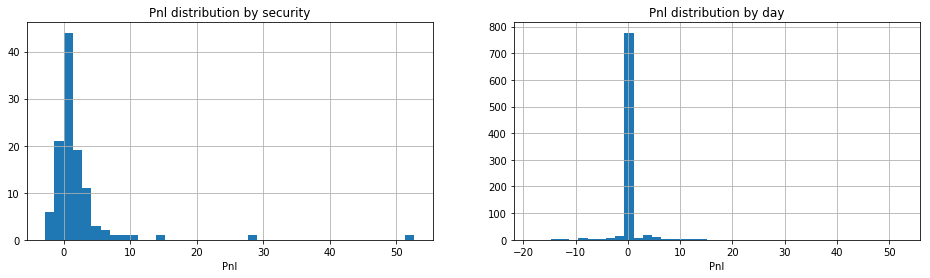

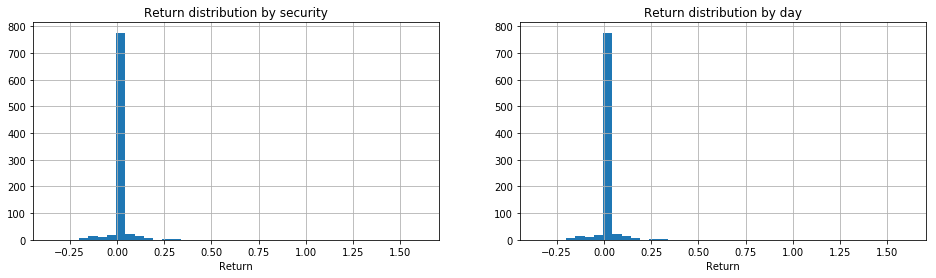

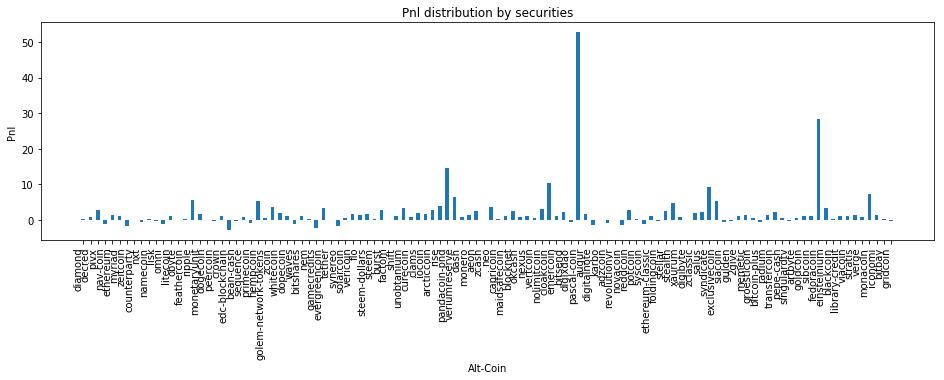

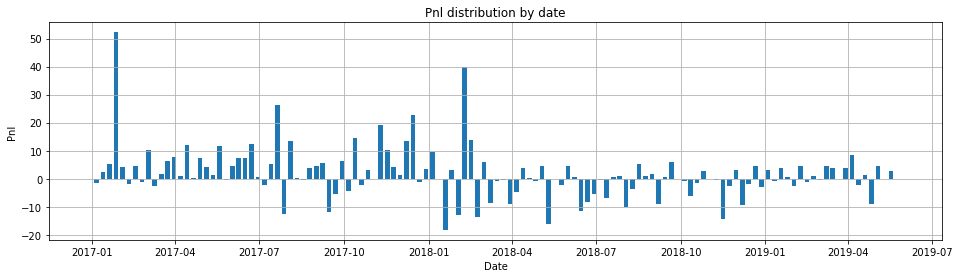

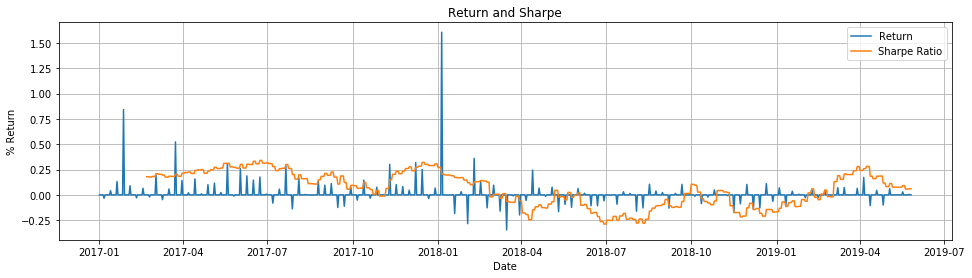

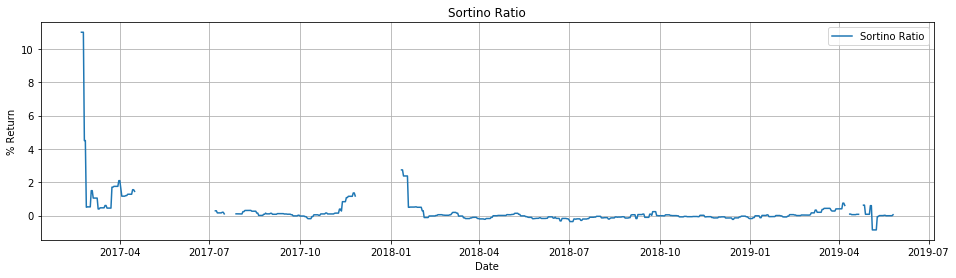

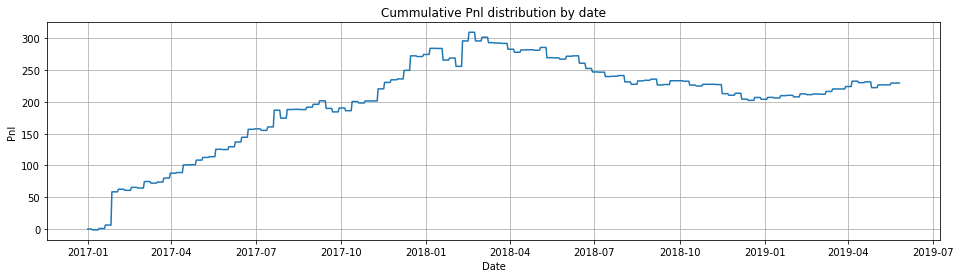

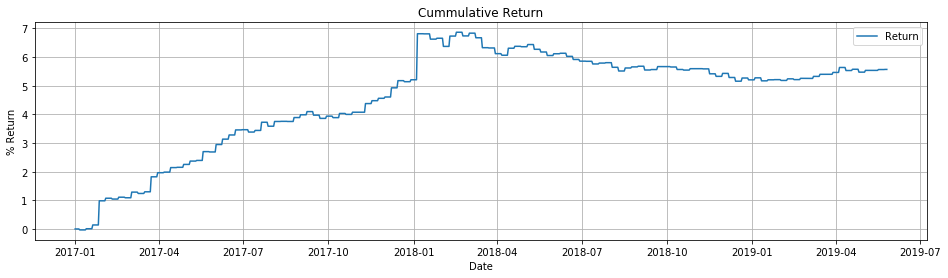

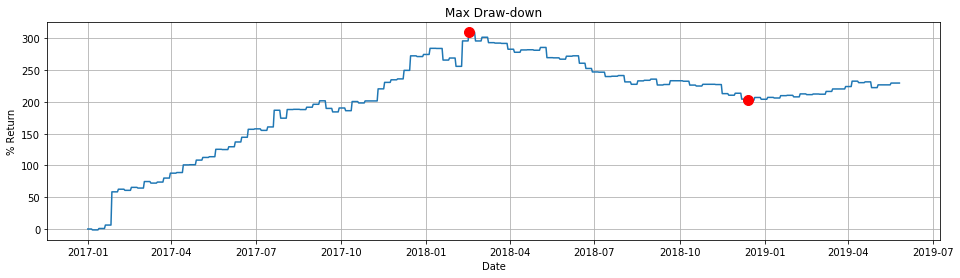

Max Drawdown is  107.1999468065531


In [317]:
analytics(df_weekly)

Total PNL is : 88.9359065009974
Pnl describe :
count    113.000000
mean       0.787043
std        5.014503
min       -0.916765
25%       -0.130965
50%        0.000000
75%        0.284165
max       51.436963
dtype: float64


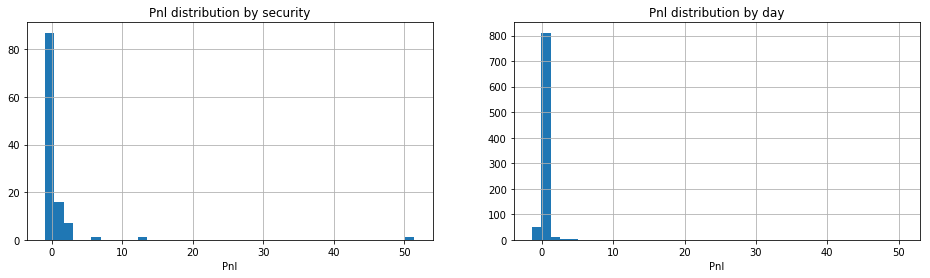

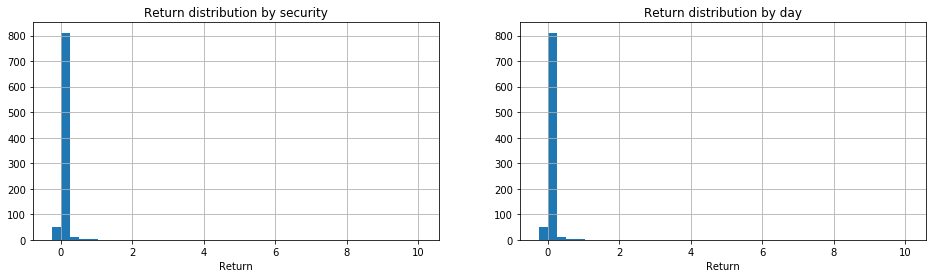

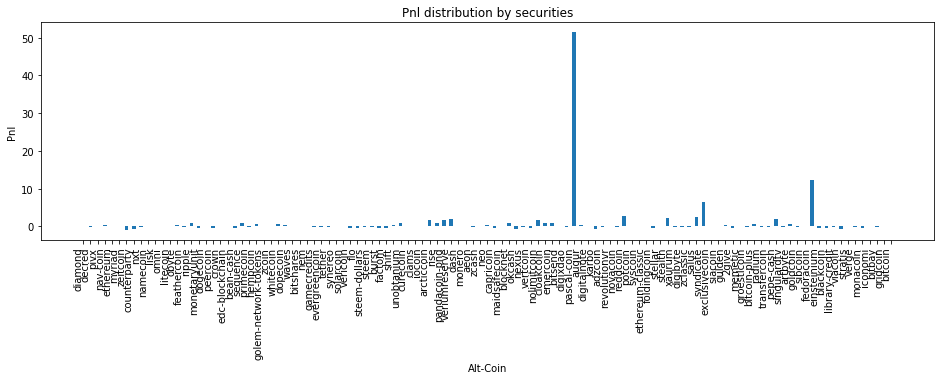

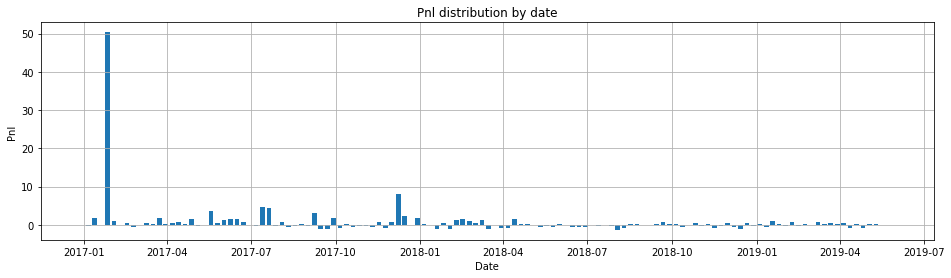

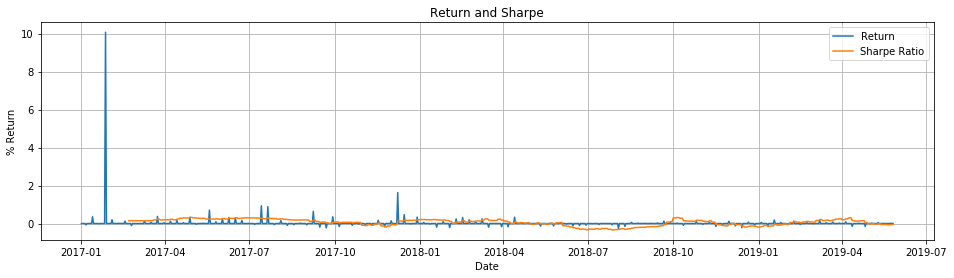

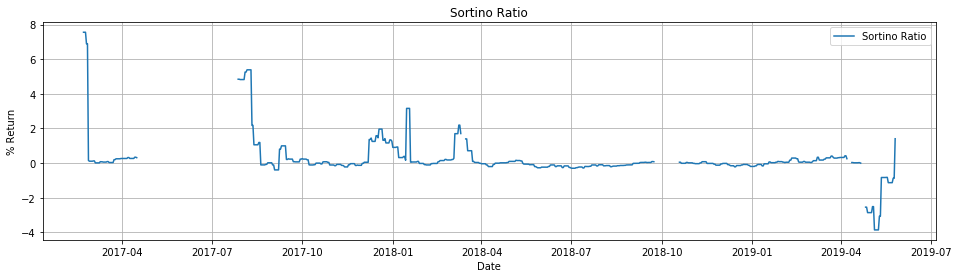

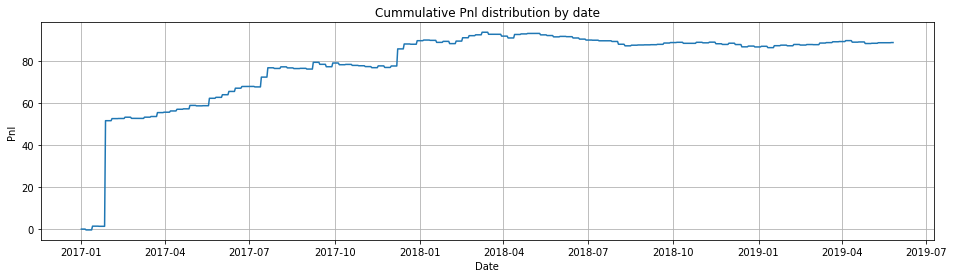

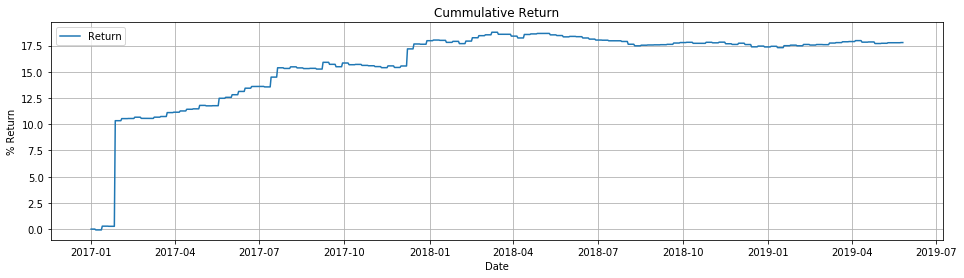

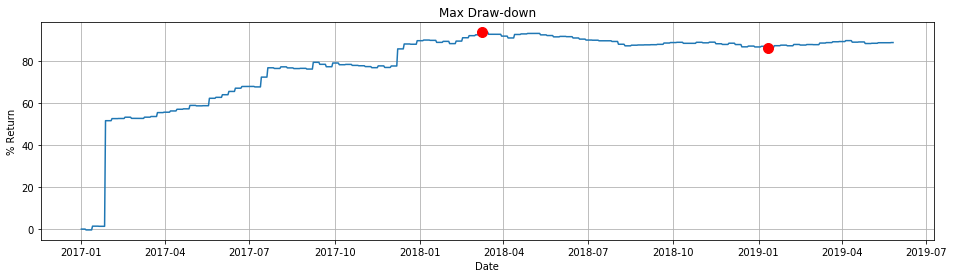

Max Drawdown is  7.342333799329239


In [310]:
analytics(df_mom_weekly)

Total PNL is : 88.77033627692607
Pnl describe :
count    114.000000
mean       0.778687
std        4.993050
min       -0.916765
25%       -0.128140
50%        0.000000
75%        0.275702
max       51.436963
dtype: float64


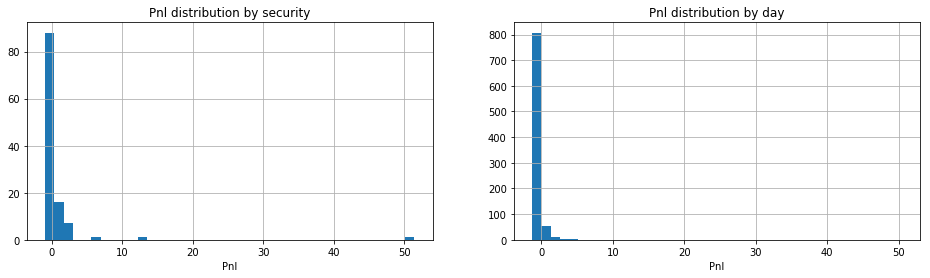

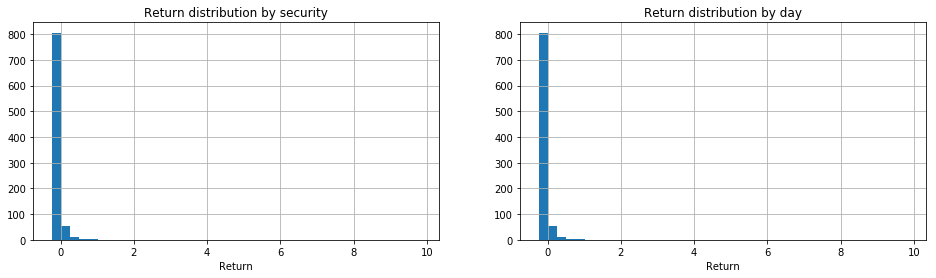

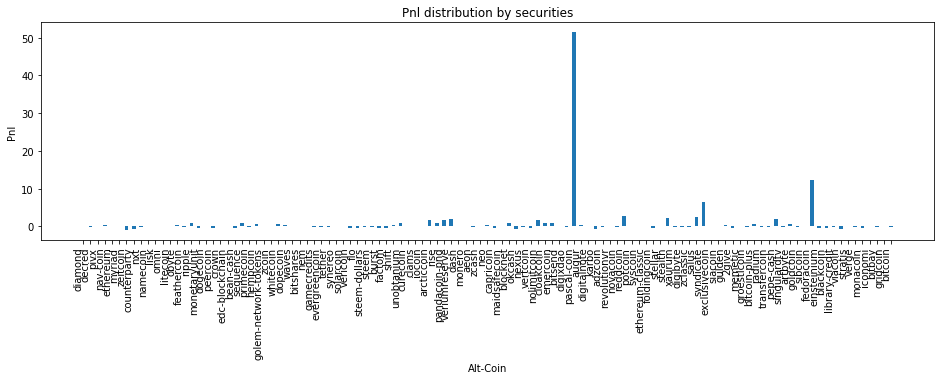

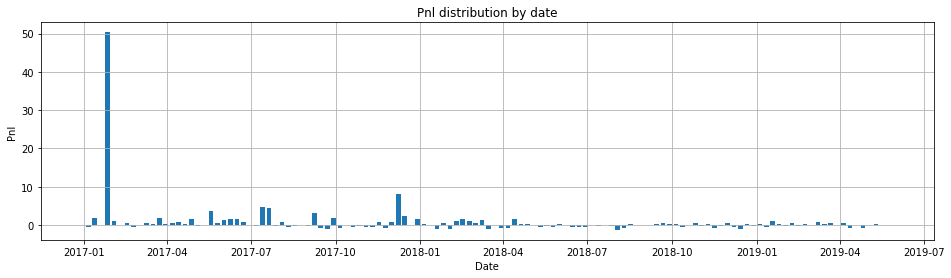

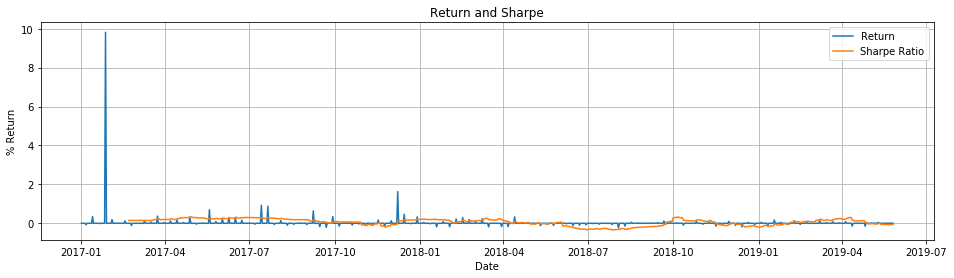

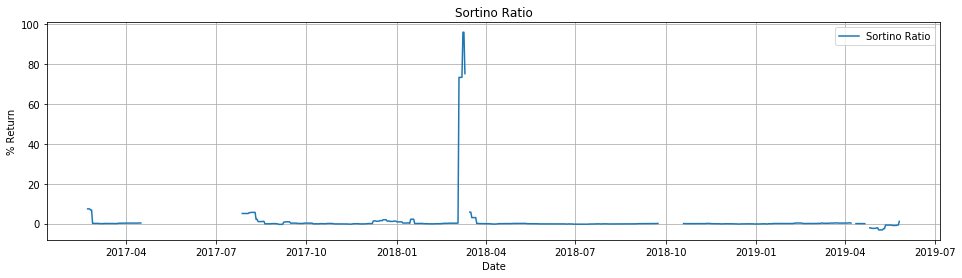

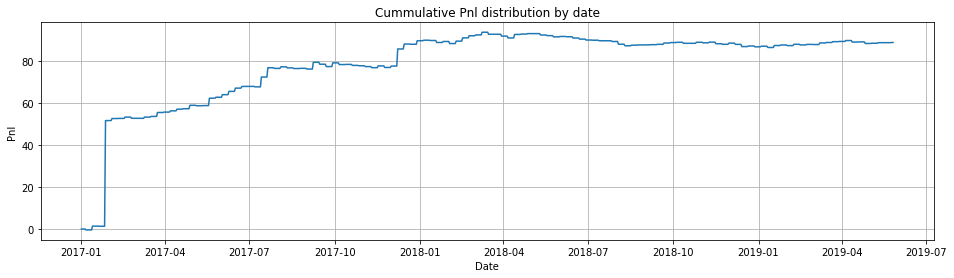

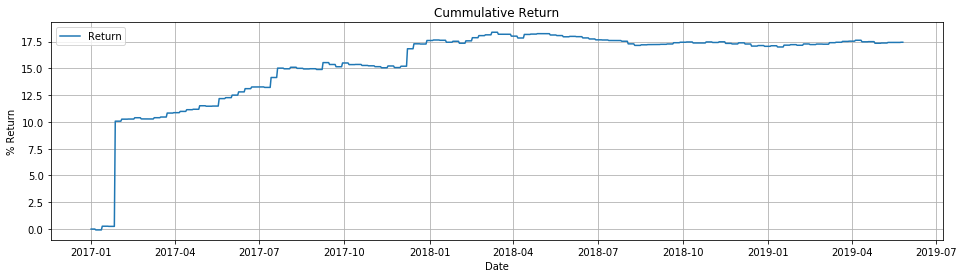

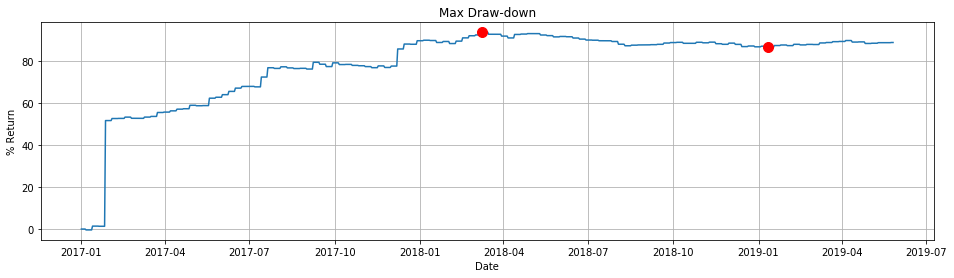

Max Drawdown is  7.262048253933912


In [311]:
tick_list.append("bitcoin")
analytics(df_mom_weekly_hedged)
tick_list.remove("bitcoin")

Total PNL is : 136.2543610316851
Pnl describe :
count    113.000000
mean       1.205791
std        5.873930
min       -4.258547
25%       -0.188980
50%        0.187804
75%        0.874950
max       50.854566
dtype: float64


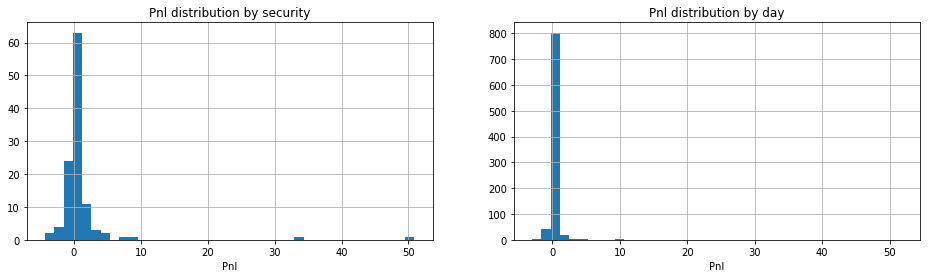

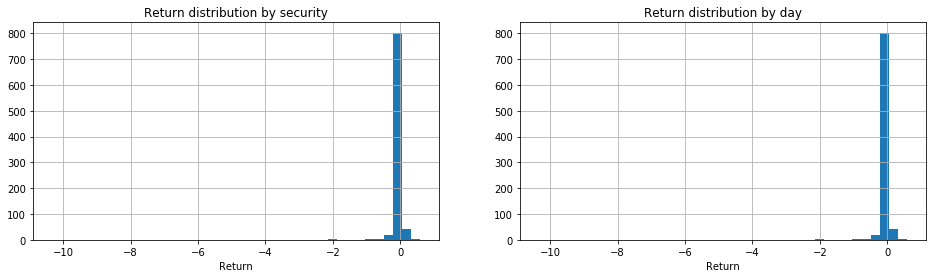

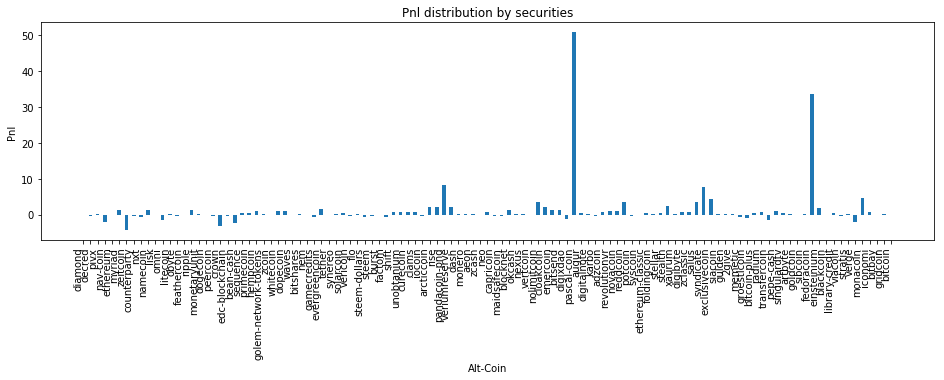

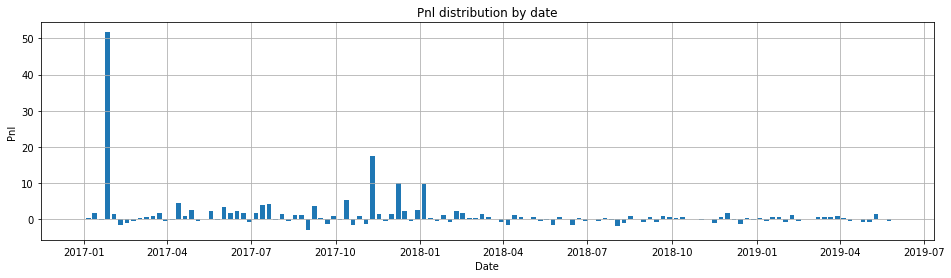

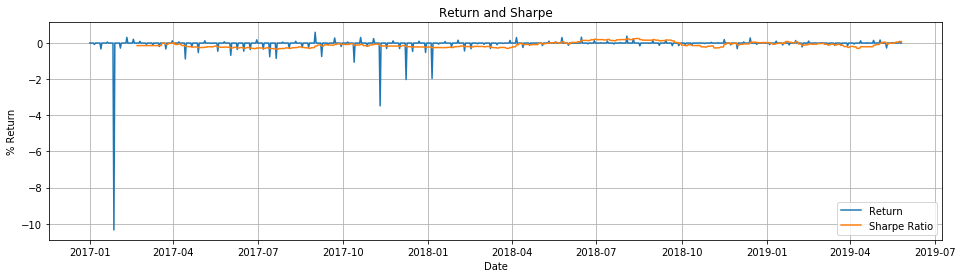

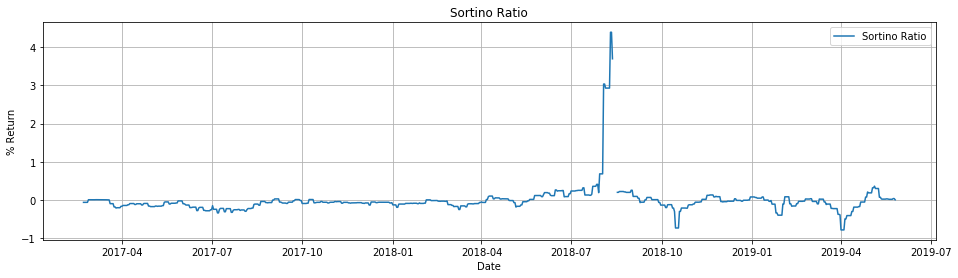

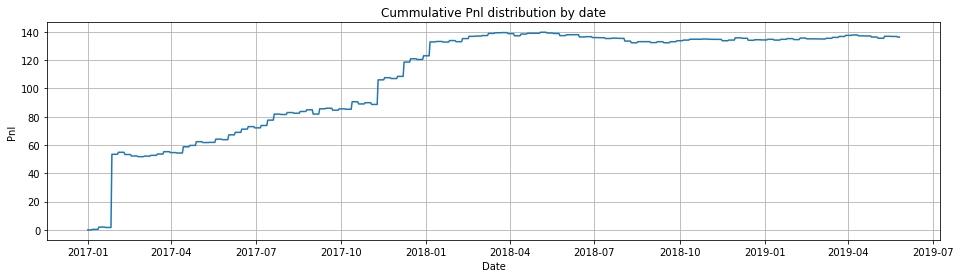

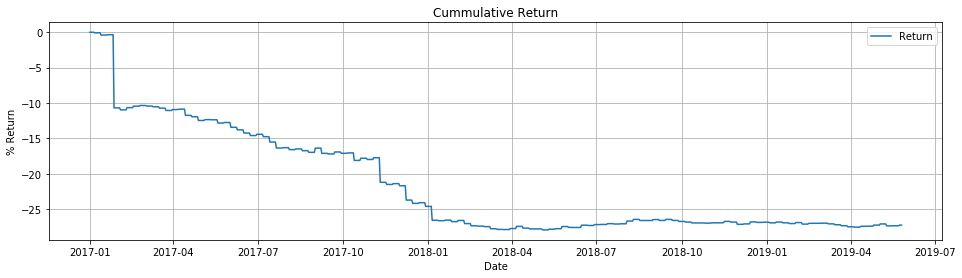

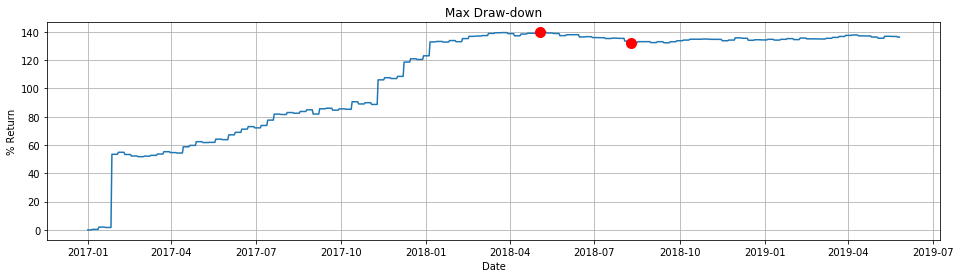

Max Drawdown is  7.445878437184632


In [312]:
analytics(df_mom_weekly_ls)

In [313]:
benchmark = pd.read_csv('Benchmark Returns.csv').set_index("ReturnDate")
benchmark.index = pd.to_datetime(benchmark.index)
benchmark.fillna(method = 'ffill', inplace = True)
benchmark.head()

,PercentReturn
ReturnDate,
2017-06-01,1.675187
2017-01-13,1.675187
2017-01-20,1.675187
2017-01-27,1.675187
2017-03-02,1.933170


In [300]:
benchmark.mean()

PercentReturn    2.17397
dtype: float64

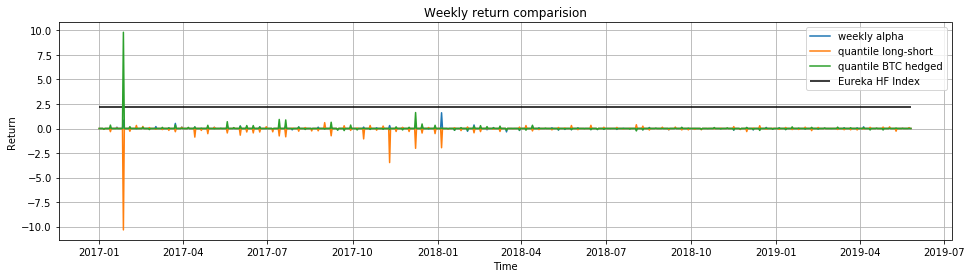

In [307]:
plt.subplots(figsize=(16,4))
plt.plot(df_weekly['return'],label="weekly alpha")
plt.plot(df_mom_weekly_ls['return'],label="quantile long-short")
plt.plot(df_mom_weekly_hedged['return'],label="quantile BTC hedged")
xmin=df_weekly.index[0]
xmax=df_weekly.index[-1]
plt.hlines(2.17397,xmin,xmax,label="Eureka HF Index")
plt.title("Weekly return comparision")
plt.plot()
plt.grid()
plt.legend()
plt.xlabel("Time")
plt.ylabel("Return")
plt.show()

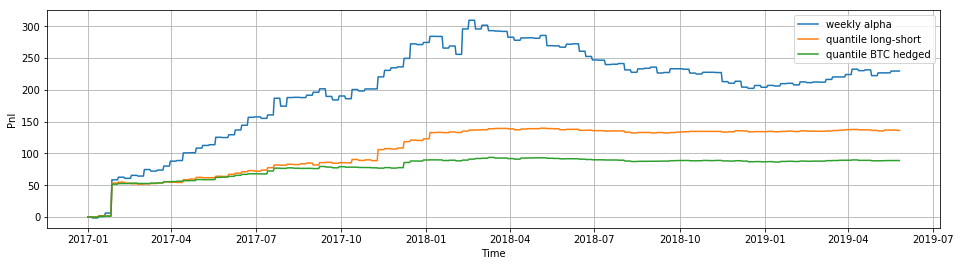

In [286]:
plt.subplots(figsize=(16,4))
plt.plot(df_weekly['agg_pnl'].cumsum(),label="weekly alpha")
plt.plot(df_mom_weekly_ls['agg_pnl'].cumsum(),label="quantile long-short")
plt.plot(df_mom_weekly_hedged['agg_pnl'].cumsum(),label="quantile BTC hedged")
plt.plot()
plt.grid()
plt.legend()
plt.xlabel("Time")
plt.ylabel("Pnl")
plt.show()

### From the above plot we can observe that weekly trading strategy is the most profitable among the above strategies and the mean reversion effect can be taken advantage of in a smaller horizon.

### Reference
1. https://coinmarketcap.com/api/
2. Altcoin-Bitcoin Arbitrage  by Zura Kakushadze and Willie Yu
3. CryptoAsset Factor Models by  Zura Kakushadze 